In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time
import datetime

In [2]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Paths
images_dir = "../images_cropped"
labels_dir = "../labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)


In [8]:
# Shuffle the data
images, labels = sklearn.utils.shuffle(images, labels, random_state=42)

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the sizes of the merged datasets
print(f"Total images: {images.shape[0]}")
print(f"Total labels: {labels.shape[0]}")

Total images: 2730
Total labels: 2730


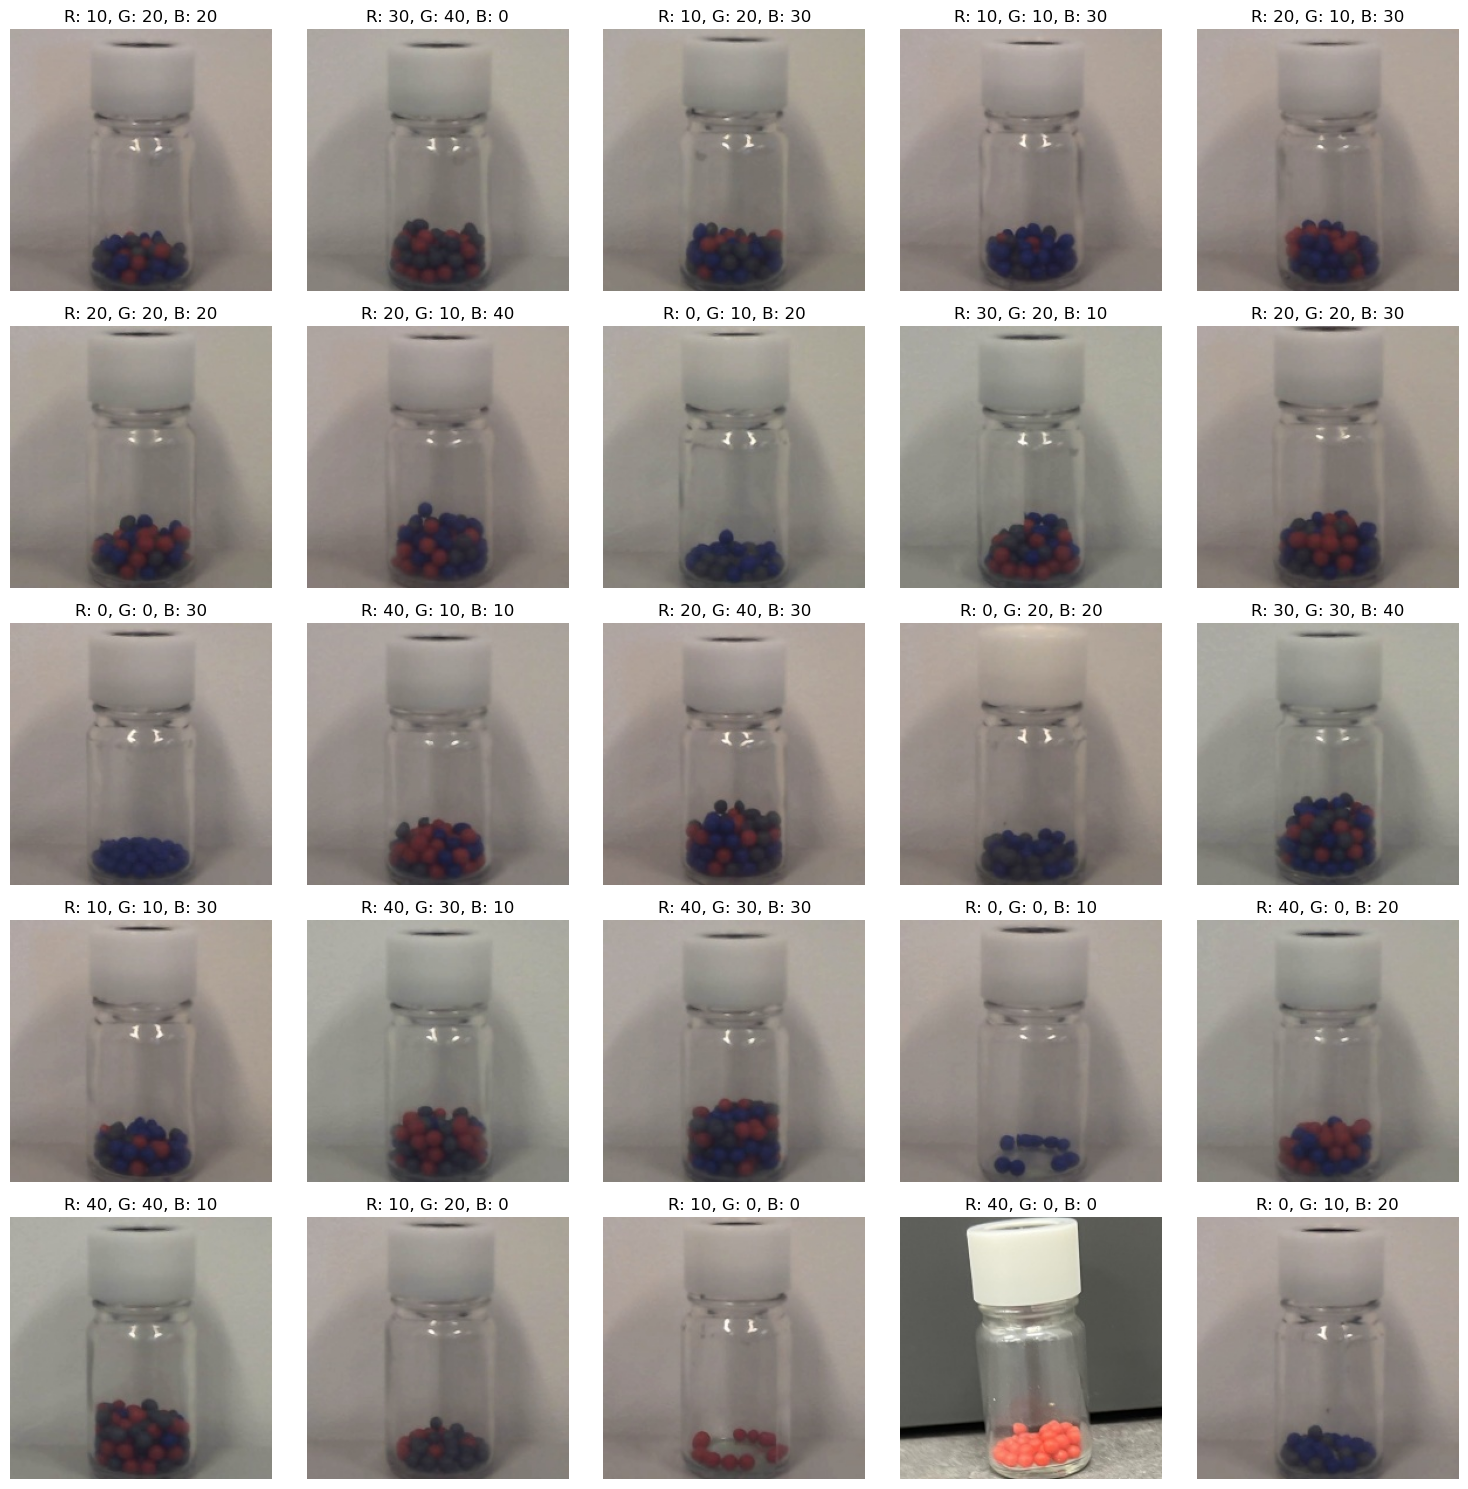

In [9]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [12]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='linear')
])(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,858,435 (91.01 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
sequential = model.layers[-1]
base_model_layers = model.layers[:-1]

# Freeze base model
for layer in base_model_layers:
    layer.trainable = False

In [14]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Augment the training data
datagen.fit(X_train)

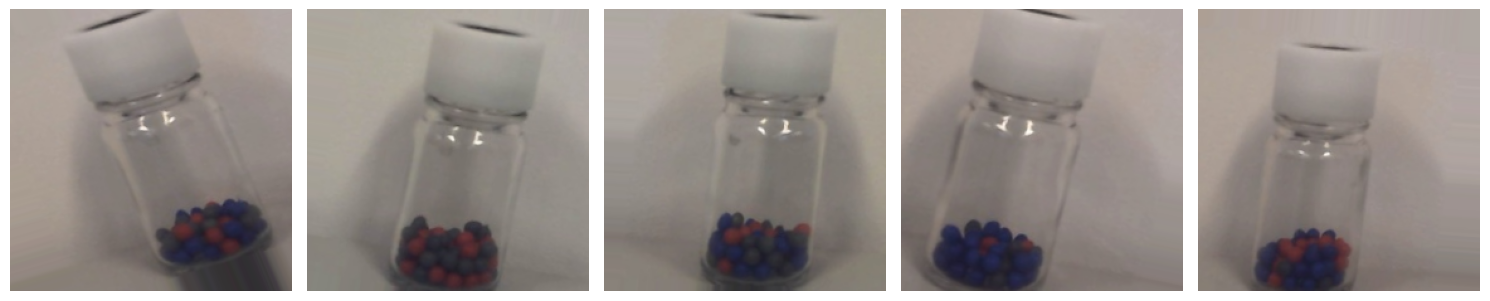

In [15]:
# Create an iterator for the data generator
image_iterator = datagen.flow(X_train, batch_size=1, shuffle=False)

# Visualize a few augmented images
num_images_to_display = 5  
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    augmented_image = image_iterator.__next__()[0]
    axs[i].imshow(augmented_image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Tensorboard
!tensorboard --logdir='../logs/fit/'

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [19]:
# Training the model for 10 epochs

# Define the tensorboard Callback
log_dir = f"../logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[tensorboard_callback]
)

Epoch 1/10


2024-12-17 08:40:02.165226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - loss: 397.2115 - mae: 16.2432 - val_loss: 218.0302 - val_mae: 12.7830
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - loss: 253.2168 - mae: 13.5666 - val_loss: 213.8324 - val_mae: 12.6225
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - loss: 237.3757 - mae: 13.1755 - val_loss: 219.6814 - val_mae: 12.8186
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - loss: 250.5203 - mae: 13.5730 - val_loss: 230.8612 - val_mae: 13.0731
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - loss: 234.8244 - mae: 13.1123 - val_loss: 220.0641 - val_mae: 12.8399
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - loss: 232.6647 - mae: 12.9311 - val_loss: 223.8384 - val_mae: 12.9335
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - loss: 233.9448 - mae: 13.0700 - val_loss: 217.7337 - val_mae: 12.7609
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - loss: 235.2583 - mae: 13.1161 - val_loss: 219.7840 - val_mae: 12.8346
Epoch 9/10


In [20]:
# Save the model in TensorFlow SavedModel format
model.save("../models/model_with_base_frozen.keras")

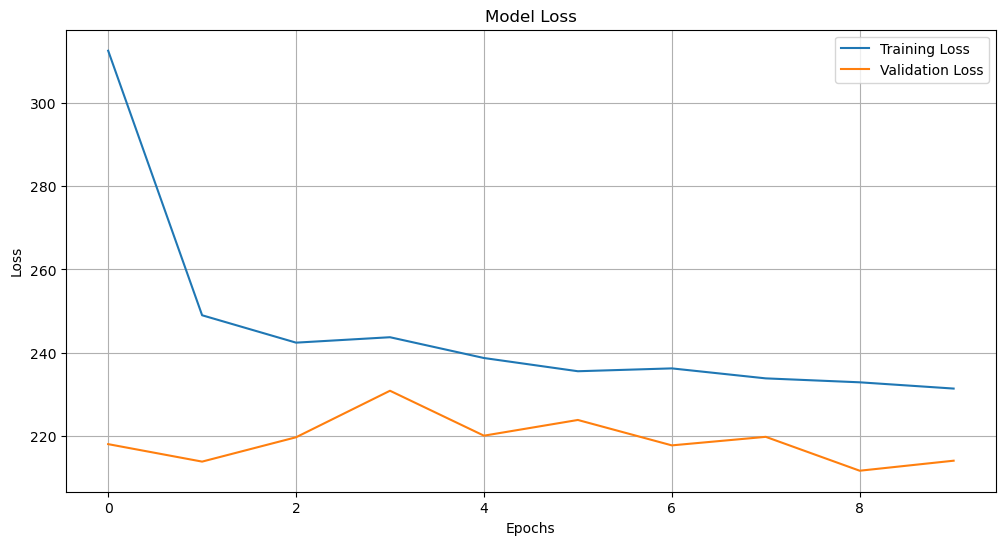

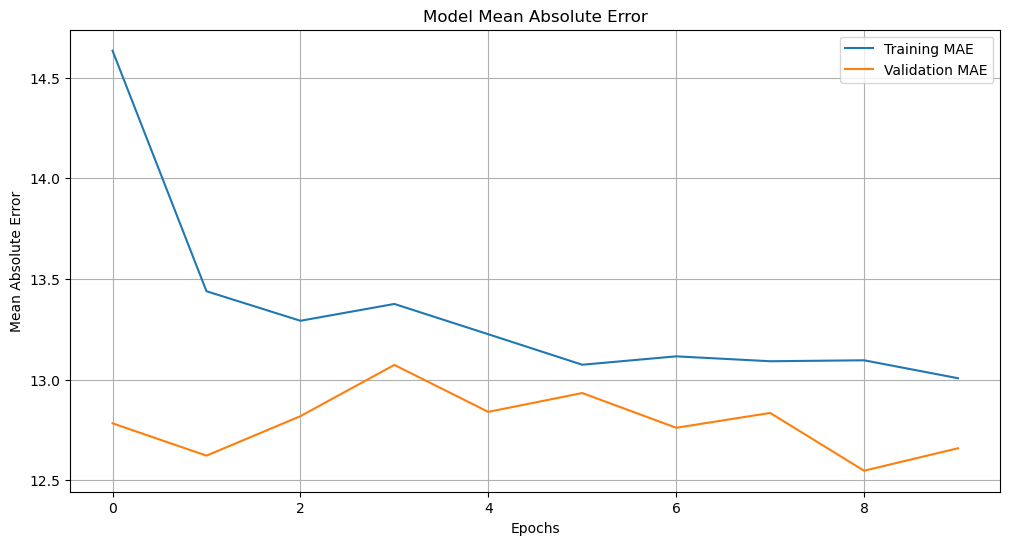

In [21]:
def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.figure(figsize=(12, 6))
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history.history)

In [22]:
# Training the model for 20 more epochs with all layers unfrozen

# Unfreeze the base model
for layer in base_model_layers:
    layer.trainable = True

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='../models/best_model.keras',       # Filepath to save the model
    monitor='val_loss',            # Metric to monitor (e.g., validation loss)
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model (weights + architecture)
    mode='min',                    # Save when 'val_loss' is minimized
    verbose=1                      # Print messages when saving
)

# Define the tensorboard Callback
log_dir = f"../logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model with the checkpoint callback
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Epoch 1/50


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 348.9203 - mae: 14.7749
Epoch 1: val_loss improved from inf to 509.85352, saving model to ../models/best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - loss: 347.6031 - mae: 14.7459 - val_loss: 509.8535 - val_mae: 17.9747
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 162.7816 - mae: 10.2923
Epoch 2: val_loss improved from 509.85352 to 495.46936, saving model to ../models/best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 162.7057 - mae: 10.2899 - val_loss: 495.4694 - val_mae: 17.7377
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - loss: 134.2266 - mae: 9.2444
Epoch 3: val_loss improved from 495.46936 to 477.38489, saving model to ../models/best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 134.1906 - mae: 9.2429 - val_loss: 477.3849 - val_mae: 17.4309
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - loss: 118.1798 - mae: 8.5960
Epoch 4: val_loss improved from 477.38489 to 455.80844, sav

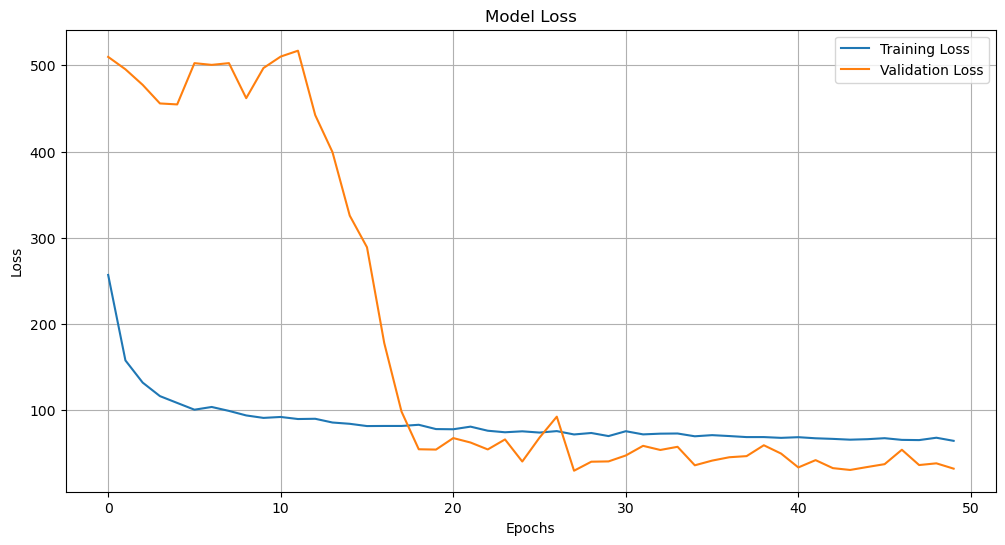

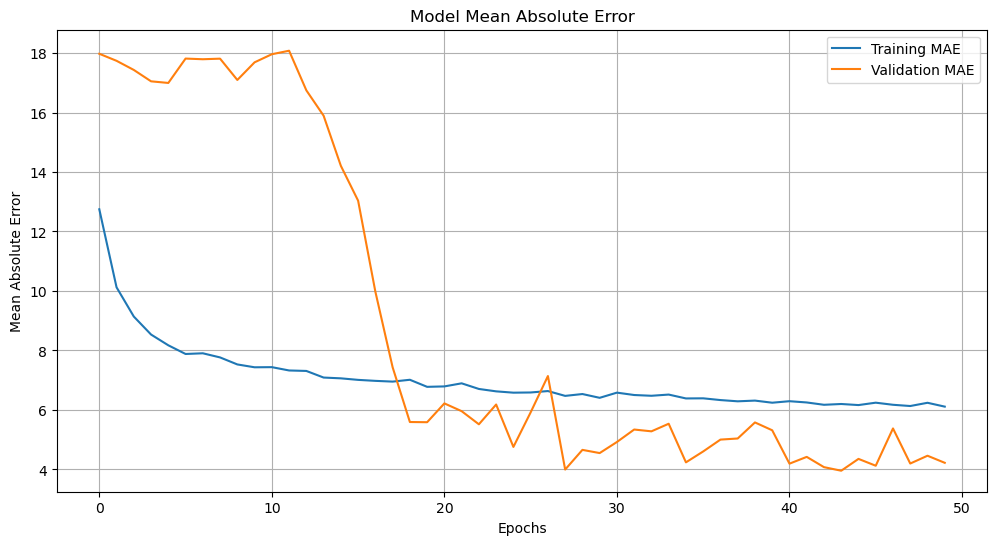

In [23]:
plot_history(history_fine_tune.history)

In [25]:
# Load the saved model
model = tf.keras.models.load_model('../models/model.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - loss: 9.7273 - mae: 2.4949
Test Loss: 10.999072074890137, Test MAE: 2.4783389568328857


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[10.923054  9.160142  8.904655]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[ 2.8934112 35.419518   2.7819629]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[15.041866 37.49927  31.58053 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[11.929885  18.517609   1.1189129]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[34.254246   1.9816171 37.649925 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[23.583868   1.6572087 16.357704 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[32.162582 13.929629 31.149448]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[21.125517 12.715935  9.677043]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[31.65108  33.366512 34.361767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[11.27578    7.1603436  9.869193 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[34.98501  21.32644  15.758906]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[34.786278 28.627209 26.92391 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[11.057173 32.217236 35.50771 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[36.21982   

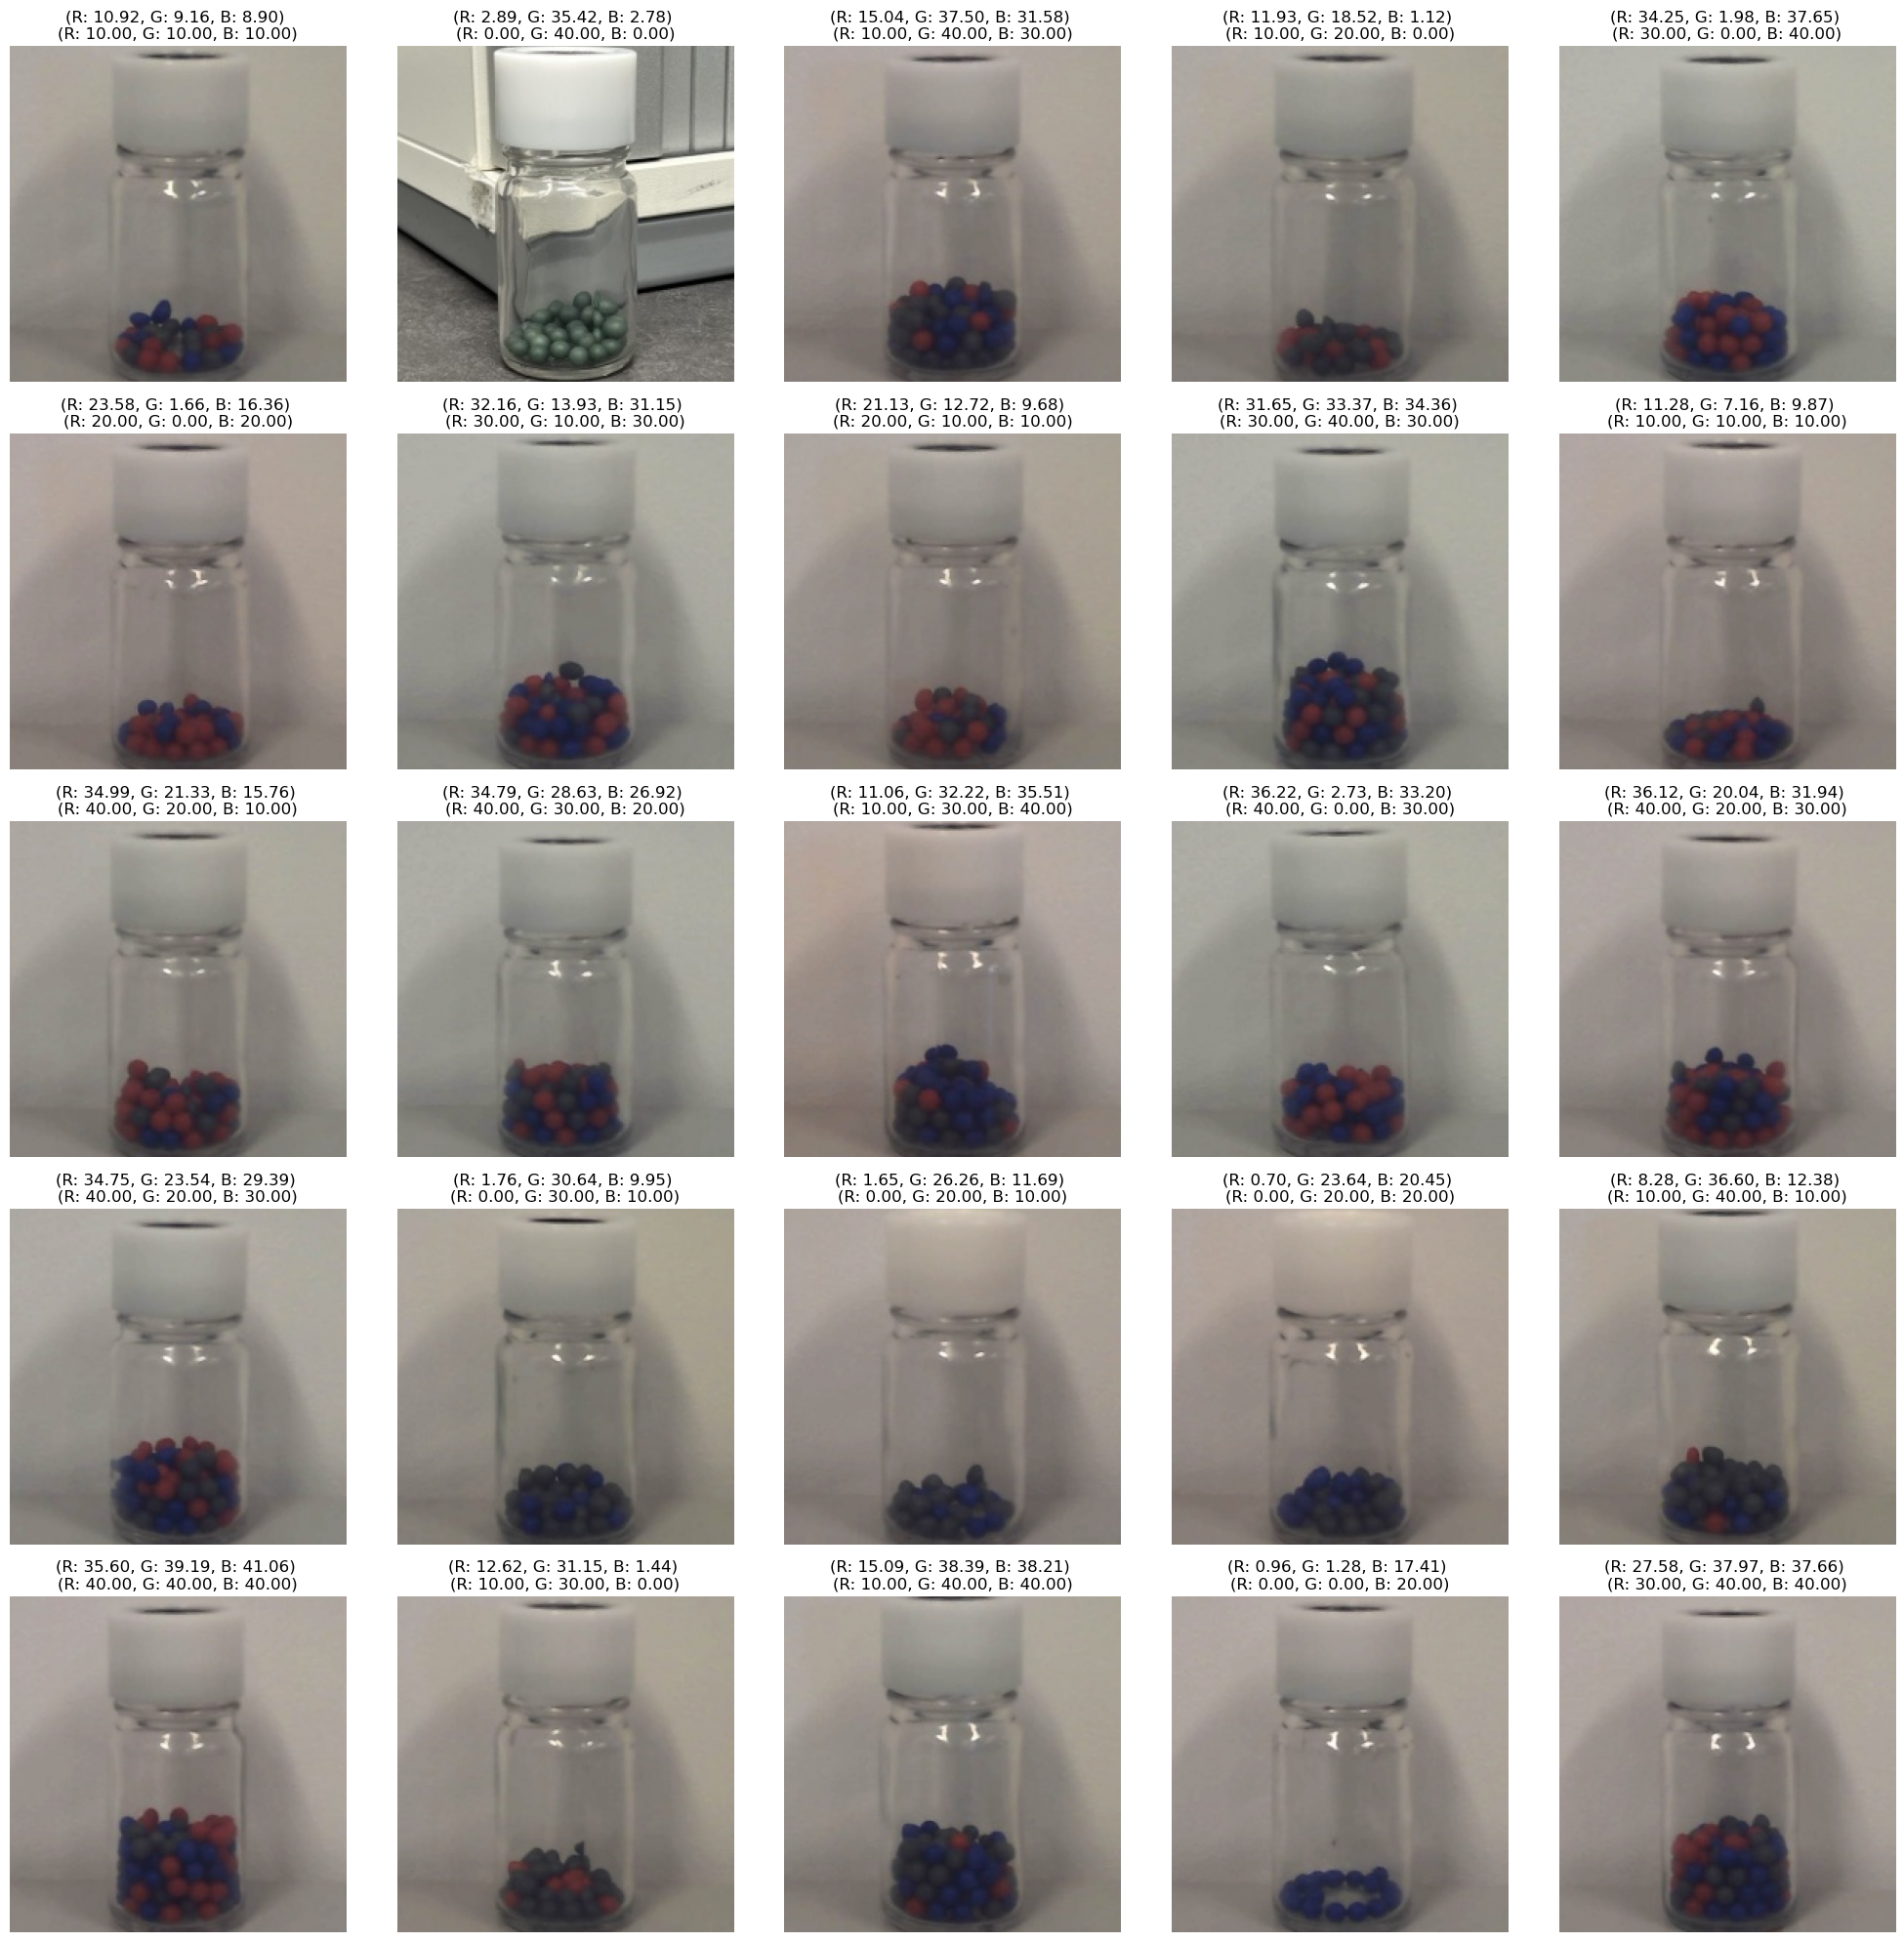

In [26]:
predictions = []

for img, label in zip(X_test[:25], y_test[:25]):
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(prediction)
    predictions.append((img, label, prediction[0]))

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image,label, prediction) in enumerate(predictions):
    axs[idx].imshow(image[0])
    axs[idx].set_title(f"(R: {prediction[0]:.2f}, G: {prediction[1]:.2f}, B: {prediction[2]:.2f}) \n(R: {label[0]:.2f}, G: {label[1]:.2f}, B: {label[2]:.2f})")    
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()